In [1]:
%load_ext line_profiler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn import preprocessing
import sklearn.linear_model as lm
import src.random_matrix as rm
import src.stat_arb as sa
import src.dim_reduction as dr
import statsmodels.api as sm
import math
import importlib
import os

PATH = '/data/hawfinch/clarkson/data/us_eq/cache'

In [7]:
df = pd.read_pickle('{}/log_returns_cleaned.pkl'.format(PATH))

# Remove stocks that have less than 99% clean data
df = df.dropna(thresh=len(df)*.99, axis=1)
# Remove days with NAs
df = df.dropna(axis=0)

spy = df['SPY']
df = df.drop('SPY', axis=1)
# Remove ETFs
df = df.drop(['SPY', 'IWM', 'EEM', 'TLT', 'USO', 'GLD', 'XLF', 'XLB', 'XLK', 'XLV', 'XLI', 'XLU', 'XLY', 'XLP', 'XLE'], axis=1, errors='ignore')

# Fit OLS to get betas - subtract mkt correlation. Technically this is lookahead bias but we observe the betas change very little anyway.
pred = pd.DataFrame(lm.LinearRegression(fit_intercept=False).fit(spy.values.reshape(-1,1), df.values).predict(spy.values.reshape(-1, 1)), 
                    index=df.index, columns=df.columns.values)
df_excess = df - pred


In [8]:
df_500_ = pd.read_pickle('{}/cleaned_multi.pkl'.format(PATH))
df_500_ = df_500_['volume'].loc[:,df.columns.values,:].unstack(1).mean().sort_values()[-500:]

df_500 = df_excess.loc[:, df_500_.index.values]
df_500

ticker,MTB,WRI,PVH,AVB,SLG,TTI,ARW,RJF,EV,ELY,...,ORCL,EBAY,F,GE,CSCO,INTC,MSFT,BAC,AAPL,IRM
date,,,,,,,,,,,,,,,,,,,,,
2000-03-29,0.016073,-0.001092,0.050644,0.011097,0.016745,0.008833,-0.063188,0.001553,0.006298,-0.008979,...,-0.049340,-0.118784,0.005798,0.042740,-0.024887,-0.029800,0.026096,-0.031223,-0.024312,0.008528
2000-03-30,0.002411,0.022952,0.009393,0.012279,-0.001725,0.094649,-0.022055,0.012811,0.039405,0.001538,...,-0.029736,0.060917,0.059240,-0.007566,-0.010733,-0.016437,-0.018381,0.003313,-0.059375,0.008659
2000-03-31,-0.004412,-0.011925,0.029579,-0.003653,-0.019664,0.011745,0.029158,0.023048,0.030100,-0.011725,...,-0.018672,-0.176811,-0.027952,-0.032486,0.034272,0.023948,0.015508,0.013820,0.064595,0.002806
2000-04-03,0.037012,0.000649,0.010001,-0.012249,-0.002161,-0.008582,-0.052704,-0.023861,-0.022927,-0.006028,...,-0.022465,-0.213076,0.016133,0.027475,-0.065758,-0.017295,-0.162440,0.047682,-0.024946,-0.015319
2000-04-04,-0.000972,0.019644,-0.016406,0.010378,-0.003639,-0.003075,0.054817,-0.051935,-0.056567,-0.000341,...,-0.003088,0.162646,0.051612,-0.036114,0.012226,0.025526,-0.017888,-0.012250,-0.037859,-0.005727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-17,0.005678,0.005127,-0.008575,0.007908,0.011859,-0.052776,-0.026229,0.007926,-0.009895,-0.013502,...,0.005411,-0.001947,-0.003106,-0.005672,0.015872,-0.005999,0.000161,0.003482,0.001420,-0.003629
2019-05-20,0.017427,-0.005862,-0.017671,-0.006658,-0.000661,0.024555,0.012627,0.016340,-0.004139,-0.034196,...,-0.007374,-0.001043,0.006727,-0.004663,0.002530,-0.021732,-0.007541,0.010381,-0.024489,-0.009896
2019-05-21,-0.004471,0.004079,0.013449,-0.000109,0.001691,-0.003567,0.009809,0.001124,0.060385,-0.020708,...,-0.001579,-0.010565,-0.014315,-0.001960,-0.002547,0.009163,-0.004110,-0.003885,0.009140,0.000361


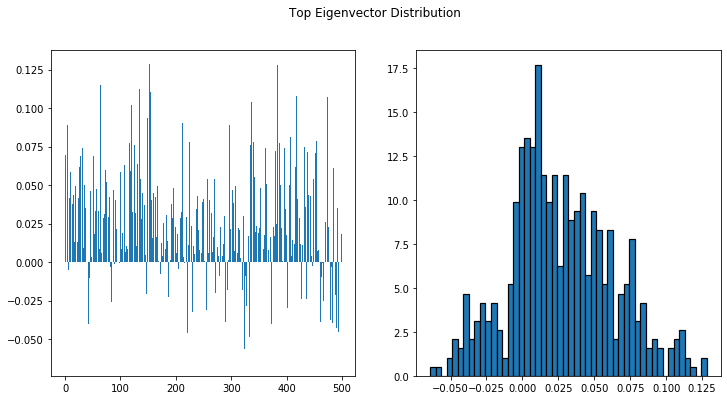

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
pca = PCA()
pca.fit_transform(df_500)
top = -pca.components_[0]
axs[0].bar([i for i in range(len(top))], top)
axs[1].hist(top, bins=50, density=True, linewidth=1.2, edgecolor='black')
fig.suptitle('Top Eigenvector Distribution')
fig.savefig('top_ev.png')

In [10]:
importlib.reload(dr)
importlib.reload(sa)

def backtest(df_lr, strats, df_exc=None, benchmark=None, save=False, it=500):    
    i = 0
    tfmrs = sa.Transforms()
    for strat in strats:
        strat.register_transforms(tfmrs)
        strat.setup(df_lr)
    for index, row in df_lr.iterrows():
        for strat in strats:
            strat.calibrate_portfolio(df_lr, index, tfmrs)
        i += 1
        if i % it == 0 and i > 250: print('Iteration: {}'.format(i))

    for strat in strats:
        strat.pnl_reconciliation(df_lr, filter_outliers=True)
        print(sa.sharpe_ratio_test(strat.lr))

    rets = [strat.cum_ret for strat in strats]
    rets = pd.concat(rets, axis=1) * benchmark.std()
    rets.plot(figsize=(10,6))
    if benchmark is not None:
        benchmark.cumsum().plot(label='SPY returns')
    plt.legend()
    if save:
        try:
            os.mkdir('figs')
        except FileExistsError:
            pass
        plt.savefig('figs/{}.png'.format(pd.Timestamp.now()))

The following code produces the figure for the correlation PCA choice of $k$ method used in the paper:

Registered Corr_pca_252
Iteration: 1000
Iteration: 2000
Iteration: 3000
Iteration: 4000
[pca|PctVar=50|sp=5|cal=5|win=252    0.7
dtype: float64, array([0.00172251])]
[pca|PctVar=75|sp=5|cal=5|win=252    0.74
dtype: float64, array([0.00085892])]
[pca|PctVar=95|sp=5|cal=5|win=252    0.66
dtype: float64, array([0.00234073])]
[pca|Rmt|sp=5|cal=5|win=252    0.74
dtype: float64, array([0.00090352])]


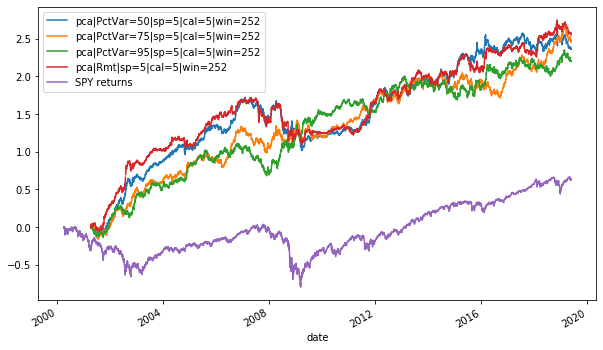

In [11]:
w = 252
cal = 5
strats = [sa.StArbFm(dr.Pca(pct_var=50, corr=True), cal_freq=cal, window_len=w), \
          sa.StArbFm(dr.Pca(pct_var=75, corr=True), cal_freq=cal, window_len=w), \
          sa.StArbFm(dr.Pca(pct_var=95, corr=True), cal_freq=cal, window_len=w), \
          sa.StArbFm(dr.Pca(rmt=True, corr=True), cal_freq=cal, window_len=w)]

backtest(df_500, strats, df_excess, benchmark=spy, save=True, it=1000)
# %lprun -f dr.RPca.fit backtest(df_500, strats, df_excess, benchmark=spy)

In [ ]:
strats = [sa.StArbFm(dr.RPca(), cal_freq=5, window_len=w),]
backtest(df_500, strats, df_excess, benchmark=spy, save=True, it=100)

pca|Rmt|sp=5|cal=5|win=60   2004-11-19
dtype: datetime64[ns]


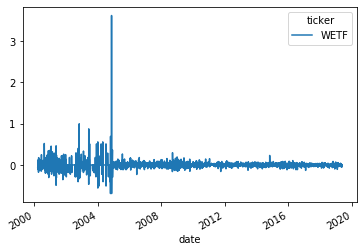

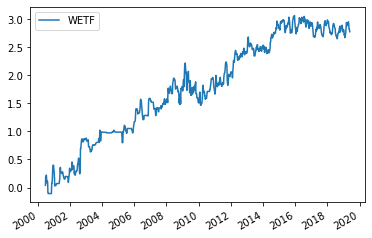

In [543]:
ix = strats[1].lr.loc['2004'].idxmax()
print(ix)
err_ticker = strats[1].portfolios.loc[ix].abs().idxmax(axis=1)
df.loc[:, err_ticker].plot()
(strats[0].portfolios.loc[:, err_ticker] * -1).cumsum().plot()

Text(0.5, 1.0, 'Number of Significant Principal Components')

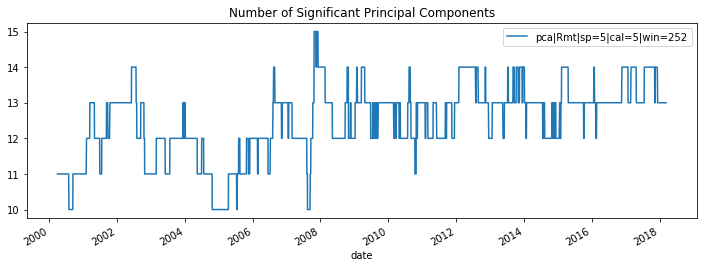

In [19]:
# pcs_df = pd.concat([pd.DataFrame(strat.n_pcs, index=df.index, columns=[strat.id]) for strat in strats], axis=1)
pcs_df = pd.DataFrame(strats[-1].n_pcs, index=df.index, columns=[strats[-1].id])
pcs_df.iloc[:-300].plot(figsize=(12, 4))
plt.title('Number of Significant Principal Components')


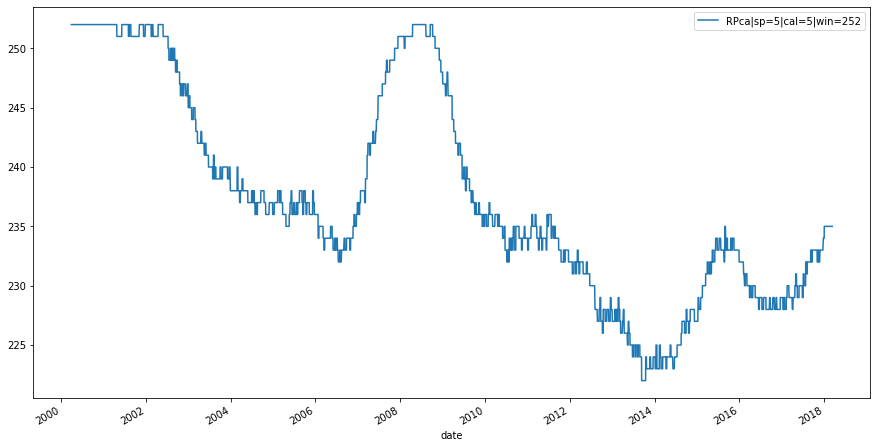

In [837]:
pcs_df = pd.DataFrame(rpca.n_pcs, index=df_500.index, columns=[rpca.id])#pd.concat([pd.DataFrame(strat.n_pcs, index=df.index, columns=[strat.id]) for strat in strats], axis=1)
pcs_df.iloc[:-300].plot(figsize=(15, 8))
# pcs_df.iloc[:-300].plot(figsize=(10, 6))
plt.savefig('dim_rpca.png')

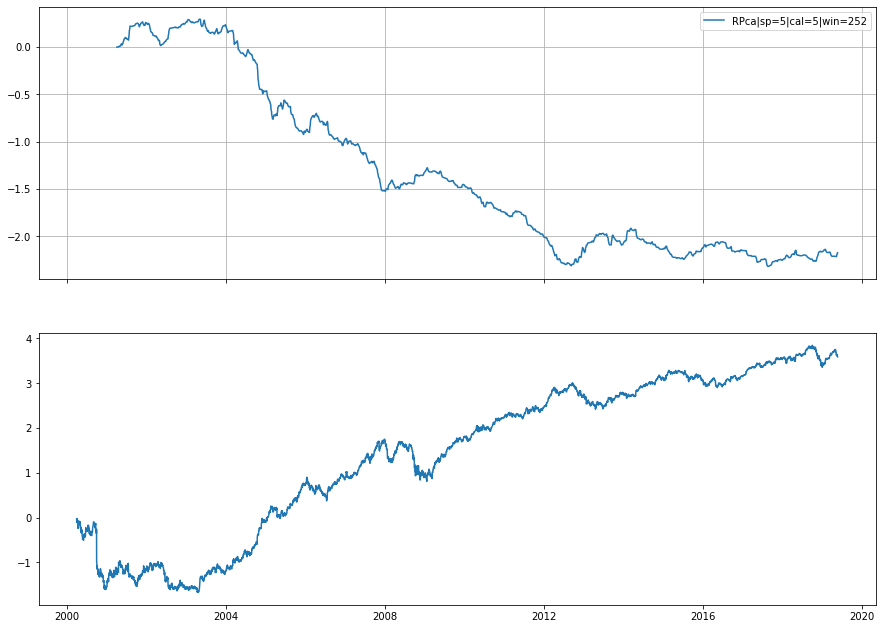

In [768]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(15, 11))
for strat in strats:
    ax[0].plot((strat.portfolios['AAPL']).cumsum(), label=strat.id)
ax[1].plot(df['AAPL'].cumsum())
ax[0].grid()
ax[0].legend()
fig.savefig('aapl_resid.png')

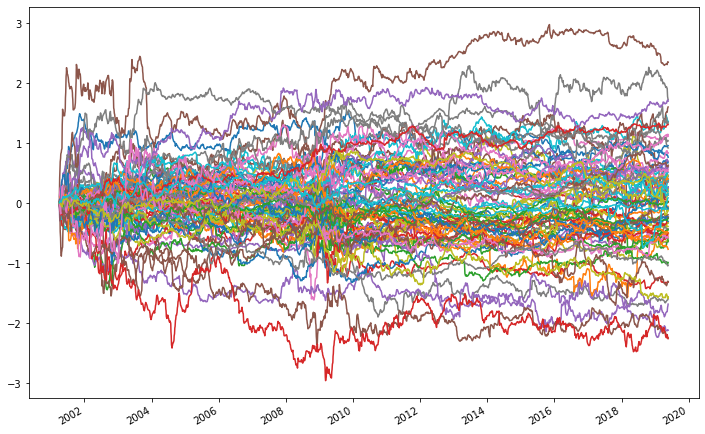

In [678]:
(strats[-1].portfolios.iloc[:, 20:100] * -1).cumsum().plot(legend=False, figsize=(12, 8))
plt.savefig('resids.png')

The following cell contains code for simulating a dataset to show that the method is able to recover the residual in a simulated case where we know what the residual should be:

In [ ]:
n = df.shape[0]
p = df.shape[1]
residuals = sm.tsa.arma_generate_sample(ar=[1], ma=[1, -0.95], nsample=(n, p))
# residuals = np.random.normal(0,1,size=(n,p))

# Gaussian returns + mean reverting residuals.
test_prices = np.array([np.random.normal(0,1) * np.ones(p) for i in range(n)]) + residuals
test_prices = pd.DataFrame(test_prices, index=df.index, columns=df.columns.values)
test_prices['AAPL'].plot()

In [ ]:
rand = pd.DataFrame(np.random.normal(size=df.shape), index=df.index, columns=df.columns)
backtest(rand, strats, df_excess, benchmark=spy)

In [21]:
# def bt(df_lr, df_exc=None, benchmark=None):
#     pca = PCA(n_components=0.50)
#     returns = np.zeros(len(df_lr))
#     i = 0
#     for index, row in df_lr.iloc[60:].iterrows():
#         ix = df_lr.index.get_loc(index)
#         window = df_lr.iloc[ix-60:ix]
#         fr = pca.fit_transform(window)
#         models = lm.LinearRegression(fit_intercept=False).fit(fr, window)
#         weights = -(window - models.predict(fr)).ewm(span=5).mean().iloc[-1]
#         returns[i] = weights.values.dot(row.values)
#         if i % 500 == 0: print(i)
#         i+= 1
#     return returns
# r = bt(df, df_excess, benchmark=spy)
from scipy import stats

def bt(df_lr, df_exc=None, benchmark=None):
    scaler = StandardScaler()
    pca = PCA(n_components=0.50)
    corr_pca = Pipeline([('s', scaler), ('pca', pca)])
    returns = np.zeros(len(df_lr))
    i = 0
    for index, row in df_lr.iloc[60:].iterrows():
        ix = df_lr.index.get_loc(index)
        window = df_lr.iloc[ix-60:ix]
        win_cen = pd.DataFrame(scale(window, with_mean=True, with_std=False),
                               index=window.index, columns=window.columns.values)
        fr = pca.fit_transform(win_cen)
#         fr = np.matmul(window.values, pca.components_.T)
        models = lm.LinearRegression(fit_intercept=False).fit(fr, win_cen)
        weights = -1 * (win_cen - models.predict(fr)).ewm(span=5).mean().iloc[-1]
        returns[i] = weights.values.dot(row.values)
        if i % 500 == 0: print(i)
        i+= 1
    print('i: {} | len(returns): {}'.format(i, len(returns)))
    return returns[:i]
rsp = bt(df, df_excess, benchmark=spy)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
i: 4753 | len(returns): 4813
